In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectA as im
import imagetools.provided as im1
%matplotlib notebook

# I) Question 4:

In [2]:
%matplotlib notebook
x=plt.imread('assets/starfish.png')
shape= x.shape
nu=im.kernel('motion')
H_r = im.RandomMasking(shape, 0.4)
H_b = im.Convolution(shape, nu, separable=None)
y= H_b(x)
z= H_r(x)
fig, axes = plt.subplots(ncols=3, figsize=(7,3))
im1.show(x, ax=axes[0])
axes[0].set_title('Identity')
im1.show(y, ax=axes[1])
axes[1].set_title('Blur')
im1.show(z, ax=axes[2])
axes[2].set_title('Masking')
fig.show()

<IPython.core.display.Javascript object>

# I) Question 5:

## For the Identity operator:

In [3]:
H_i=im.Identity((24,16))
x= np.random.rand(H_i.ishape[0], H_i.ishape[1])
y= np.random.rand(H_i.oshape[0], H_i.oshape[1])
LHS= (H_i(x)*y).sum()
RHS= (H_i.adjoint(y)*x).sum()
np.isclose(LHS, RHS)

True

## For the Convolution operator:

In [4]:
nu=im.kernel('motion')
H_c=im.Convolution((24,16), nu)
x= np.random.rand(H_c.ishape[0], H_c.ishape[1])
y= np.random.rand(H_c.oshape[0], H_c.oshape[1])
LHS= (H_c(x)*y).sum()
RHS= (H_c.adjoint(y)*x).sum()
np.isclose(LHS, RHS)

True

## For the Random masking operator:

In [5]:
H_r=im.RandomMasking((24,16,3), 0.4)
x= np.random.rand(H_r.ishape[0], H_r.ishape[1], H_r.ishape[2])
y= np.random.rand(H_r.oshape[0], H_r.oshape[1], H_r.oshape[2])
LHS= (H_r(x)*y).sum()
RHS= (H_r.adjoint(y)*x).sum()
np.isclose(LHS, RHS)

TypeError: Cannot cast ufunc add output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

# I) Question 6:
#to be implemented

# II) Question 8:

In [ ]:
x0=plt.imread('assets/fish.png')
sig = 10/255
y = x0 + sig * np.random.randn(x0.shape[0], x0.shape[1],x0.shape[2])
x=im.heat_diffusion(y, 100, 1/8, scheme='implicit')

In [ ]:
plt.figure()
im1.show(x)

# II) Question 13:

In [6]:
x0=plt.imread('assets/fish.png')
sig = 10/255
y = x0 + sig * np.random.randn(x0.shape[0], x0.shape[1],x0.shape[2])
x, alpha=im.anisotropic_diffusion(y, 100, 1/8, g=None, return_conductivity=True)
im1.show(x)

KeyboardInterrupt: 

In [32]:
def tensorize(v, nurho):
    n1, n2, p = v.shape[:3]
    M = np.zeros((n1, n2, p, p))
    v_pq = np.zeros((n1,n2))
    for k in range(p):
        for l in range(p):
            if np.ndim(v) == 3:
                vv_pq = np.multiply(v[:,:,k],v[:,:,l])
            else:
                import pdb
#                 pdb.set_trace()
                vv_pq = np.sum(np.multiply(v[:,:,k,:],v[:,:,l,:]),axis=-1)
            #remember to sum across the three channels for the colour images
            M[:,:,k,l] = im.convolve(x = vv_pq,nu = nurho,boundary = 'periodical') 
    return M

In [33]:
def matrix_spectral_func(M, g):
    a = np.zeros_like(M)
    #find the eigenvalues of M along the last two dimension
    u,s,vh = np.linalg.svd(M, compute_uv=True)
    
    
    A = g(s)
    
    T = u @ (A[..., None] * vh)
    
    return T

In [34]:
def truly_anisotropic_step(x, z, gamma, g, nusig, nurho,
return_conductivity=False):
    
    
    #step 1
    v0 = im.grad(im.convolve(x = x,nu = nusig,boundary = 'periodical'))
    #step 2
    M = tensorize(v0,nurho)
#     import pdb
#     pdb.set_trace()
    n1,n2, p = M.shape[:3]
    #step 3
    T = matrix_spectral_func(M,g)
    #step 4

    v = np.zeros((n1,n2,p))
    if np.ndim(x) == 3:
        x0 = im.grad(x)
        v = (np.matmul(T,x0))
    else:
        x0 = im.grad(x).reshape(n1,n2,p,1)
        v = (np.matmul(T,x0)).reshape(n1,n2,p)

#     pdb.set_trace()
    #finallly
    x =z + gamma*im.div(v)

    if return_conductivity:
        return x, T
    else:
        return x


In [35]:
def anisotropic_diffusion(y, m, gamma, g=None, return_conductivity=False, scheme='explicit',variant =None):
    if variant is 'truly':
            x = y
            if len(y.shape)==3:
                C=3
            else:
                C=1
            if g==None:
                g= lambda u: 10 / (10 + 255*255*u/(np.sqrt(C)))
            nusig = im.kernel('gaussian', tau=0.2, s1=1, s2=1)
            nurho = im.kernel(name ='gaussian',tau = 0.5, s1=1,s2=2)
            
            for k in range(m):
                if scheme=='explicit':
                    
                    x, alpha= truly_anisotropic_step(x, x, gamma, g, nusig,nurho, return_conductivity=return_conductivity)
                elif scheme=='implicit':
                    x, alpha= im.cg(lambda z: im1.rad_step(x, z, -gamma, g, nusig, return_conductivity=return_conductivity), x)
            if return_conductivity:
                return x, alpha
            else:
                return x
    if variant is None:
            x = y
            if len(y.shape)==3:
                C=3
            else:
                C=1
            if g==None:
                g= lambda u: 10 / (10 + 255*255*u/(np.sqrt(C)))
            nusig = kernel('gaussian', tau=0.2, s1=1, s2=1)
            for k in range(m):
                if scheme=='explicit':
                    x, alpha= anisotropic_step(x, x, gamma, g, nusig, return_conductivity=return_conductivity)
                elif scheme=='implicit':
                    x, alpha= cg(lambda z: rad_step(x, z, -gamma, g, nusig, return_conductivity=return_conductivity), x)
            if return_conductivity:
                return x, alpha
            else:
                return x
        

<IPython.core.display.Javascript object>


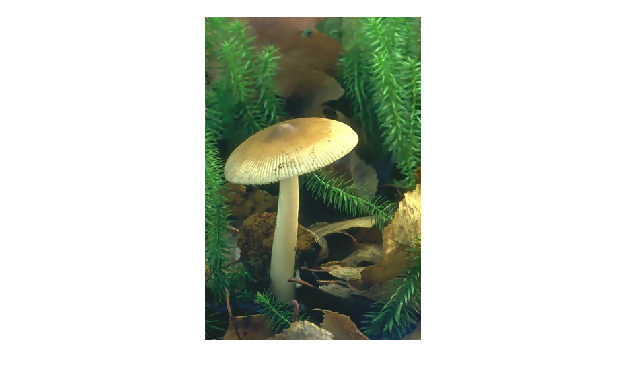

In [36]:
x0=plt.imread('assets/mushroom.png')
sig = 10/255
y = x0 + sig * np.random.randn(x0.shape[0],x0.shape[1],x0.shape[2])
x, alpha=anisotropic_diffusion(y, 100, 1/8, g=None, return_conductivity=True,variant='truly')
plt.figure()
im1.show(x)

<IPython.core.display.Javascript object>


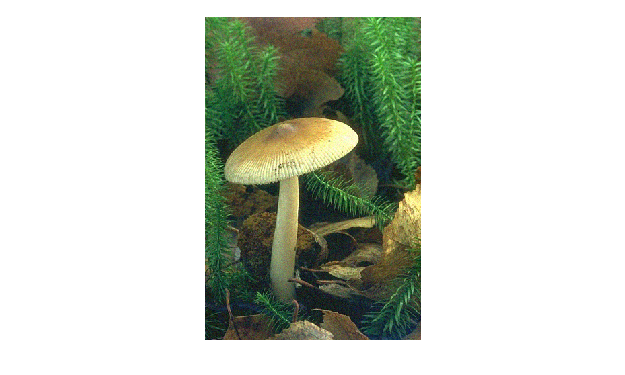

In [14]:
plt.figure()
im1.show(y)

In [37]:
im.psnr(x0,x)

33.15478970756847

In [25]:
x0=plt.imread('assets/mushroom.png')
sig = 10/255
y = x0 + sig * np.random.randn(x0.shape[0],x0.shape[1],x0.shape[2])
x, alpha=anisotropic_diffusion(y, 5, 20/8, g=None, return_conductivity=True,variant='truly',scheme='implicit')
plt.figure()
im1.show(x)

AttributeError: module 'imagetools.provided' has no attribute 'rad_step'